In [1]:
import requests as requests

btc_rates = requests.get("https://shakepay.github.io/programming-exercise/web/rates_CAD_BTC.json").json()
eth_rates = requests.get("https://shakepay.github.io/programming-exercise/web/rates_CAD_ETH.json").json()

rates = {
    'ETH': {rate['createdAt'][:10]: rate['midMarketRate'] for rate in eth_rates},
    'BTC': {rate['createdAt'][:10]: rate['midMarketRate'] for rate in btc_rates},
}


def get_rate(currency, date):

    try:
        return rates[currency][date]

    except KeyError:
        entries = 0
        total = 0
        for k, v in rates[currency].items():
            if k.startswith(date[:9]):
                entries += 1
                total += float(v)
                return total/entries
            elif k.startswith(date[:7]):
                entries += 1
                total += float(v)
                return total/entries
            elif k.startswith(date[:5]):
                entries += 1
                total += float(v)
                return total/entries


In [2]:
import requests
from rates import get_rate

response = requests.get("https://shakepay.github.io/programming-exercise/web/transaction_history.json")
data = response.json()
transactions = sorted(data, key=lambda d: d['createdAt'])

balance = {
    "CAD": 0,
    "BTC": 0,
    "ETH": 0
}

net_worth_by_day = {}
for txn in transactions:
    currency = txn['currency']
    amount = txn['amount']
    date = txn['createdAt'][:10]

    if txn['direction'] == 'debit':
        balance[currency] -= amount

    if txn['direction'] == 'credit':
        balance[currency] += amount

    if txn['direction'] is None:
        balance[currency] -= amount

        to_currency = txn['to']['currency']
        to_amount = txn['to']['amount']
        balance[to_currency] += to_amount

    txn['balance'] = balance

    net = (
            balance['CAD'] +
            (balance['BTC'] * get_rate('BTC', date)) +
            (balance['ETH'] * get_rate('ETH', date))
    )/1000000
    net_worth = float(format(net, ".3f"))

    txn['net_worth'] = net_worth
    net_worth_by_day.update({date: net_worth})


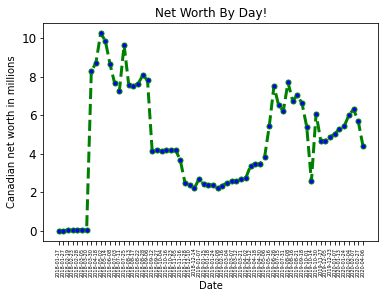

In [3]:
from transactions import net_worth_by_day

import matplotlib.pyplot as plt


x = list(net_worth_by_day.keys())[::3]
y = list(net_worth_by_day.values())[::3]

plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=5)
plt.xlabel('Date')
plt.ylabel('Canadian net worth in millions')

plt.xticks(ticks=range(len(x)), rotation=90, size=5)
plt.yticks(size=12)

plt.title('Net Worth By Day!')

plt.show()